# DataCamp Certification Case Study

## Cars price prediction

### Project Brief

You have been hired as a data scientist at Discount Motors, a used car dealership in the UK. The dealership is expanding and has hired a large number of junior salespeople. Although promising, these junior employees have difficulties pricing used cars that arrive at the dealership. Sales have declined 18% in recent months, and management would like your help designing a tool to assist these junior employees.

To start with, they would like you to work with the Toyota specialist to test your idea(s). They have collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the head of sales in a 10 minute presentation. The head of sales has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

### Import needed libraries

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [173]:
toyota = pd.read_csv('data/toyota.csv')
toyota.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [174]:
toyota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


From just the above information we realize that there are main steps and information to do the pre-processing of the presented data to then deal with the model, such as:
- Encoding the presented categories
- Normalize the values
- We realize that there are no non-null values, so we don't need to deal with this problem

### Exploratory Data Analysis and data preprocessing
We will perform an exploratory analysis of the data to identify possible patterns and outliers among the data, facilitating data cleaning and future data transformations 

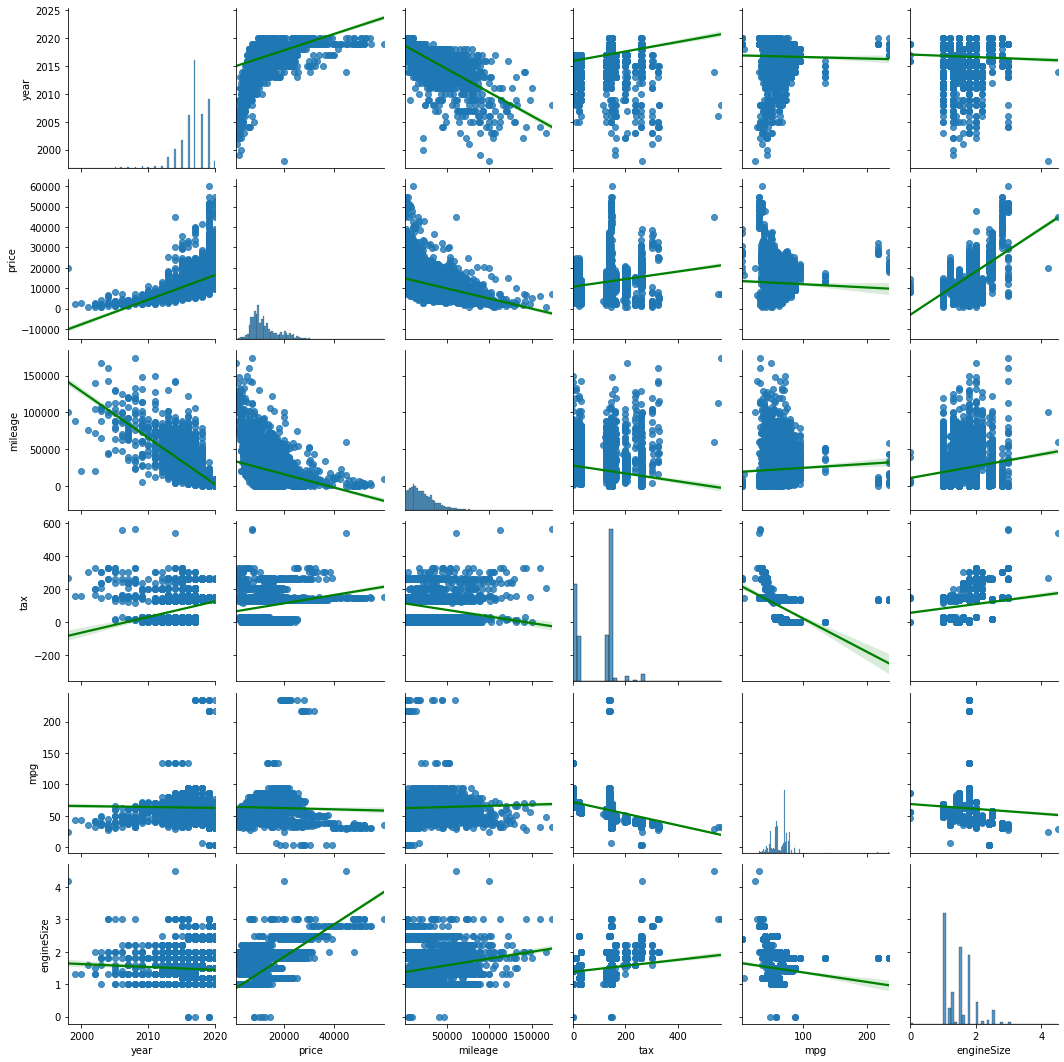

In [175]:
sns.pairplot(toyota,kind="reg",plot_kws={'line_kws':{'color':'green'}})
plt.show()

There are many outliers in the data, however we can list several pieces of information that we identified from the above pairplot, some of the pieces of information are:
- The higher the 'engineSize' the higher the 'price'
- The lower the 'mileage' the lower the 'price
- The higher the 'tax' the lower the 'mpg'

#### Describing the numerical and categorical data better

In [176]:
toyota.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


In [177]:
toyota.describe(exclude=np.number)

,model,transmission,fuelType
count,6738,6738,6738
unique,18,4,4
top,Yaris,Manual,Petrol
freq,2122,3826,4087


In [178]:
toyota['model'].unique()

array([' GT86', ' Corolla', ' RAV4', ' Yaris', ' Auris', ' Aygo', ' C-HR',
       ' Prius', ' Avensis', ' Verso', ' Hilux', ' PROACE VERSO',
       ' Land Cruiser', ' Supra', ' Camry', ' Verso-S', ' IQ',
       ' Urban Cruiser'], dtype=object)

In [179]:
# Removing white space in string
toyota['model'] = toyota['model'].str.strip()

toyota['model'].unique()

array(['GT86', 'Corolla', 'RAV4', 'Yaris', 'Auris', 'Aygo', 'C-HR',
       'Prius', 'Avensis', 'Verso', 'Hilux', 'PROACE VERSO',
       'Land Cruiser', 'Supra', 'Camry', 'Verso-S', 'IQ', 'Urban Cruiser'],
      dtype=object)

In [180]:
toyota['transmission'].unique()

array(['Manual', 'Automatic', 'Semi-Auto', 'Other'], dtype=object)

In [181]:
toyota['fuelType'].unique()

array(['Petrol', 'Other', 'Hybrid', 'Diesel'], dtype=object)

For these columns we can use OneHotEncoder or get_dummies to convert these categories into columns

#### Check the correlation of the data
Let's confirm some of the statements quoted in the presentation of the first pairplot to see if they are correct by correlating the data, looking at these values in a heatmap

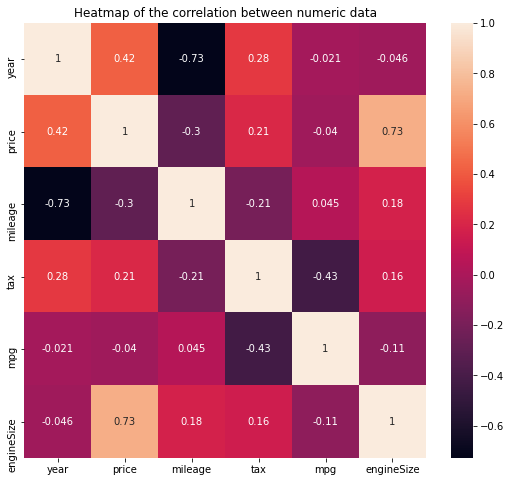

In [182]:
toyota_corr = toyota.corr()

fig,ax = plt.subplots(figsize=(9,8))

sns.heatmap(toyota_corr,annot=True,ax= ax)
ax.title.set_text('Heatmap of the correlation between numeric data')
fig.show()

We can see the information more clearly and already have new observations, such as:
- The newer the car the lower the 'mileage' (Clearly older cars have traveled more)
- The higher the 'mileage' the lower the 'mpg' (It is obvious that cars that run more tend to decrease their performance)

#### Removing biased data

Let's check if the price really increased when the junior salespeople was hired

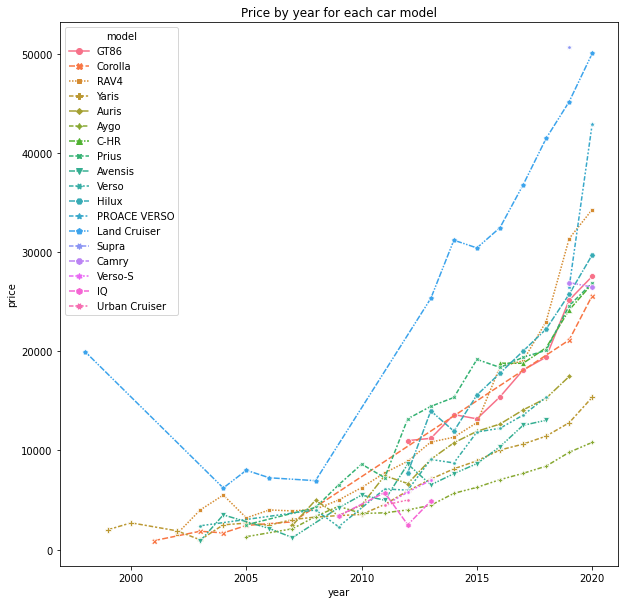

In [183]:
fig,ax = plt.subplots(figsize=(10,10))

sns.lineplot(x='year', y='price', hue='model', data=toyota, ax=ax,  style="model", markers=True, ci=None)
ax.title.set_text('Price by year for each car model')
fig.show()

As we can see in the last year the price of toyota cars really increeased, so it can be a pattern of the market

#### Check the distribuition of data
We will use the boxplot to identify the distribution of the data and check whether there is a need for normalization and removal of outliers

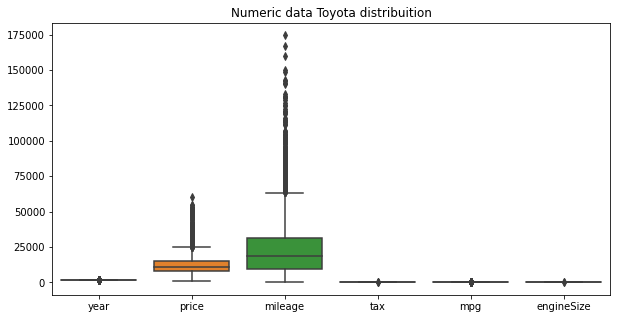

In [184]:
fig,ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=toyota,ax=ax)
ax.title.set_text('Numeric data Toyota distribuition')
fig.show()

### Removing outliers
We can confirm the outliers, if we notice the minimum and maximum values that are far away from the mean, mainly related to 'mileage', 'tax' and 'mpg', we will treat these outliers now using the percentile method of the numpy library and filter the data better, after that we will take a look at the data again through the pairplot

In [185]:
cols = ['mileage','tax','mpg','price']
toyota_filtered = toyota.copy()

Q1 = toyota_filtered[cols].quantile(0.25)
Q3 = toyota_filtered[cols].quantile(0.75)
IQR = Q3 - Q1

toyota_filtered = toyota_filtered[~((toyota_filtered[cols] < (Q1 - 1.5 * IQR)) |
                       (toyota_filtered[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

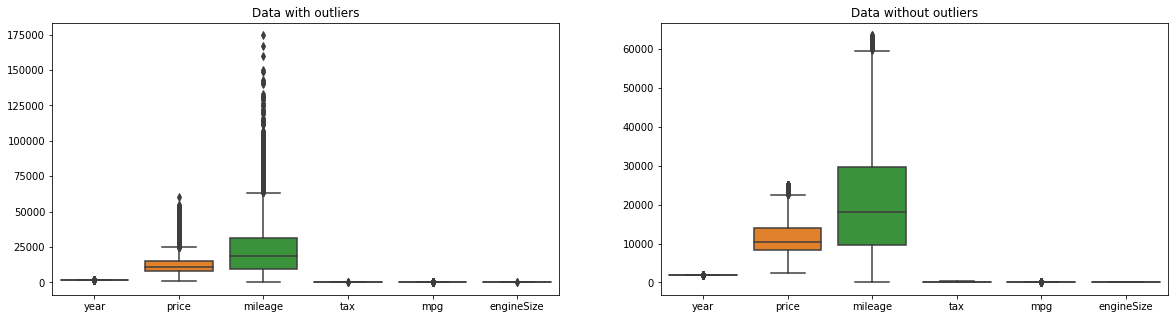

In [186]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

sns.boxplot(data=toyota,ax=ax[0])
ax[0].set_title('Data with outliers')

sns.boxplot(data=toyota_filtered,ax=ax[1])
ax[1].set_title('Data without outliers')
plt.show()

In [187]:
print('Original size:')
print(len(toyota))
print('Size after applied the filter:')
print(len(toyota_filtered))

Original size:
6738
Size after applied the filter:
6097


In [188]:
toyota_filtered.describe()

,year,price,mileage,tax,mpg,engineSize
count,6097.000000,6097.000000,6097.000000,6097.000000,6097.000000,6097.000000
mean,2016.884697,11836.309168,20741.329342,91.612268,63.072609,1.418189
std,1.749013,4794.087612,14107.031647,70.798434,11.338135,0.391501
min,2000.000000,2490.000000,2.000000,0.000000,36.200000,0.000000
25%,2016.000000,8295.000000,9675.000000,0.000000,56.500000,1.000000
50%,2017.000000,10500.000000,18102.000000,135.000000,65.600000,1.500000
75%,2018.000000,13995.000000,29608.000000,145.000000,69.000000,1.800000
max,2020.000000,25000.000000,63475.000000,300.000000,86.000000,3.000000


We noticed that many distant points disappeared and also the amount of data did not decrease sharply, we did this so that our predictive model will not have future complications

### Normalization

We see that the columns have different types of units, this can cause the model to have less accuracy and high bias, so we need to use some method to standardize this data and keep its information, we can also see through the secondary diagonal that the distribution is not Gaussian, we will then use a function from the sklearn library that will facilitate this normalization work. To confirm, let's just plot the distribution of the numeric columns

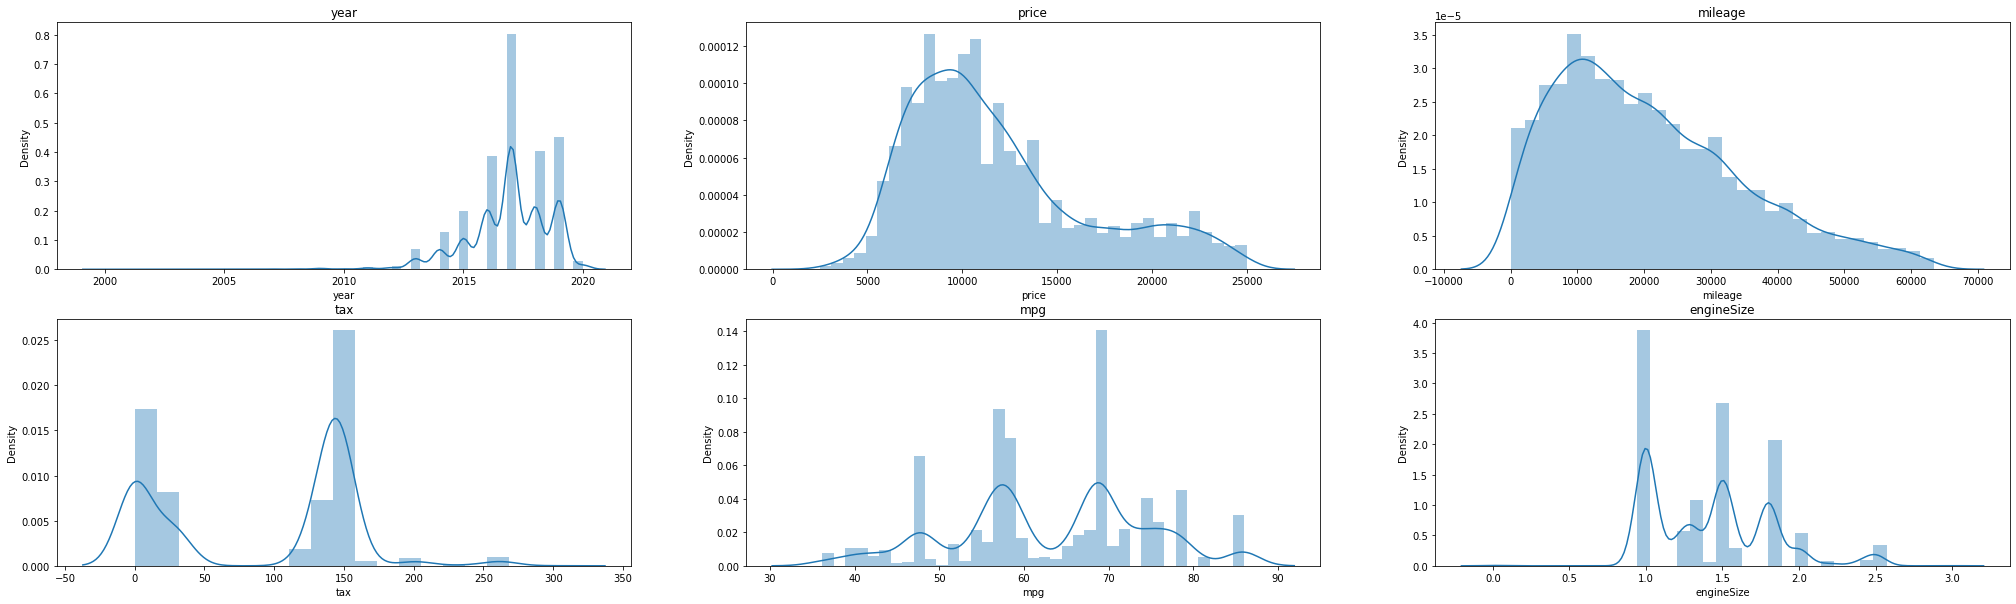

In [189]:
numeric_data = toyota_filtered.select_dtypes(include=np.number)
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(35,10))

for i, column in enumerate(numeric_data.columns):
    sns.distplot(numeric_data[column],ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(column)
    
plt.show()

In [190]:
normalizer = Normalizer()
toyota_normal_np = normalizer.fit_transform(numeric_data)

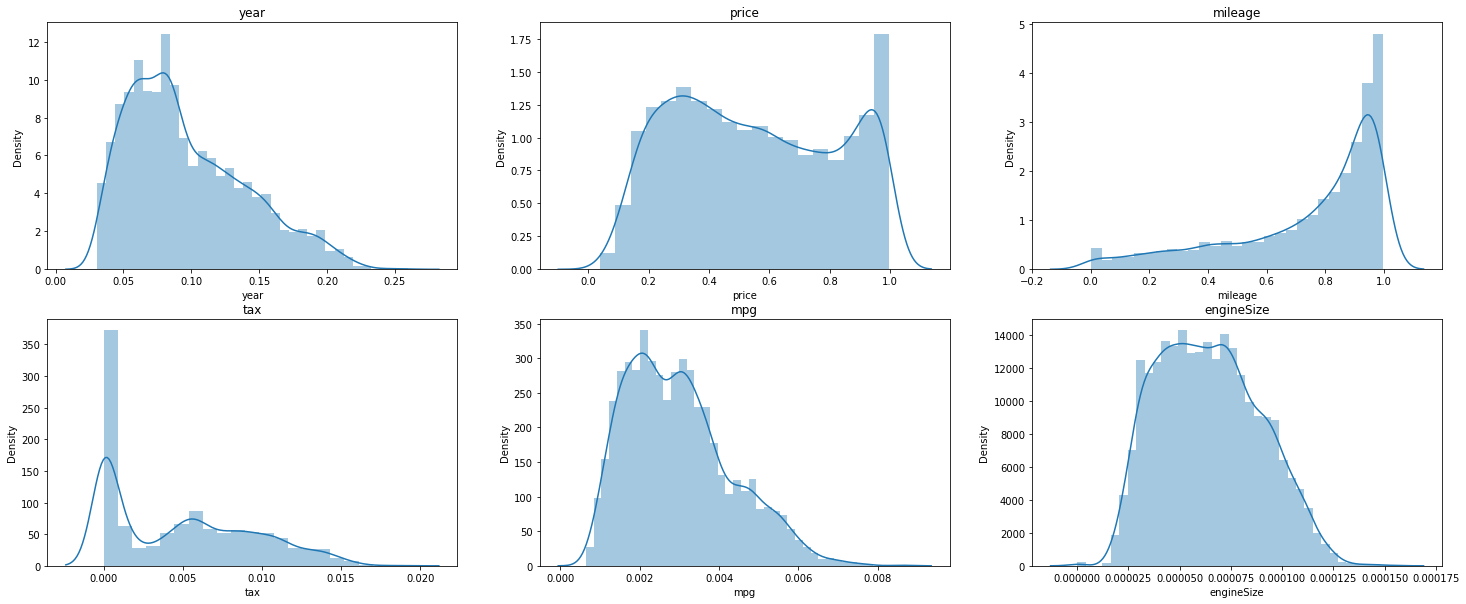

In [191]:
toyota_normal = pd.DataFrame(toyota_normal_np,columns=numeric_data.columns)

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(25,10))

for i, column in enumerate(toyota_normal.columns):
    sns.distplot(toyota_normal[column],ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(column)
    
plt.show()

#### Encoding the categorical columns

We will use the OneHotEncoder method of the sklearn library to transform the categorical columns

In [192]:
onehotencoder = OneHotEncoder()
categorical_data = toyota_filtered.select_dtypes(exclude=np.number)
categorical_data_enc = onehotencoder.fit_transform(categorical_data)
pd.DataFrame(categorical_data_enc.toarray())

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Creating the pipeline of the model

I choose RandomForestregressor because of some points, like:

- I can access the features that have more importance and interfere more in the price of the vehicle
- Even removing some outliers, some remain, but RandomForest can deal with those that remain, so they don't interfere much in the model's bias
- We can get good results using cross-validation
- Usually there is not much overfitting relative to the training data
- Even with normalization, the model can handle the difference in dimensionality

In [193]:
X = toyota_filtered.drop('price',axis=1) 
y = toyota_filtered[['price']]

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=123,test_size=0.3)

We need to do the data transformation operations inside the model pipeline, so we will use the ColumTransformer function to facilitate the transformation of the categorical data and the numerical data

In [194]:
numeric_transformer = Normalizer()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_include=np.number)),
        ("cat", categorical_transformer, selector(dtype_exclude=np.number)),
    ]
)

reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor(random_state = 0, n_jobs=-1))]
)

In [195]:
from sklearn import set_config

set_config(display="diagram")
reg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', Normalizer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff33c10e4f0>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff34be7c850>)])),
                ('regressor',
                 RandomForestRegressor(n_jobs=-1, random_state=0))])

### Tuning the model with RandomizedSearchCV

We will cross-validate and tune the hyperparameters so that we can find the best parameters for the model we have chosen, so we created this dictionary to store the possible combinations of parameters that are commonly used in this type of model, i've already made a bigger dict, but it's was taking too long to fit

We need to limit the number of possible interactions and combinations, so I limited it to 5, so that after 5 interactions, it will return the best parameters tested

In [201]:
%%time
params = {
    'regressor__bootstrap': [True, False],
    'regressor__max_depth': [60, 80, 100],
    'regressor__max_features': ['auto', 'sqrt'],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__n_estimators': [1000, 1200, 1400]
}

random_search = RandomizedSearchCV(reg, param_distributions = params, n_iter = 5, cv = 3, verbose=1, random_state=0, n_jobs = -1)
random_search.fit(X_train,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 42.2 s, sys: 297 ms, total: 42.5 s
Wall time: 4min 53s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Normalizer(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7ff33c10e4f0>),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7ff34be7c850>)])),
                                             ('regressor',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=0))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'regressor__bootstrap': [True, False],
                                        'regressor__max_depth': [60, 80, 100],
                                        'regressor__max_features': ['auto',
                                                                    'sqrt'],
                                        'regressor__min_samples_leaf': [1, 2,
                                                                        4],
                                        'regressor__min_samples_split': [2, 5,
                                                                         10],
                                        'regressor__n_estimators': [1000, 1200,
                                                                    1400]},
                   random_state=0, verbose=1)

### Results

In [202]:
print('Best params for RamdomSearchCV:')
print(random_search.best_params_)

Best params for RamdomSearchCV:
{'regressor__n_estimators': 1000, 'regressor__min_samples_split': 10, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'auto', 'regressor__max_depth': 60, 'regressor__bootstrap': True}


In [203]:
# Predicting accuracy score
accuracy_score = random_search.score(X_test,y_test)

# Predicting R2 Score the Train set results
y_pred_rf_train = random_search.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = random_search.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
rmse_rf = (np.sqrt(mean_squared_error(y_test, y_pred_rf_test)))
print('Model accuracy score: ', accuracy_score)
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("RMSE: ", rmse_rf)

Model accuracy score:  0.9184865810740869
R2_score (train):  0.9658867683655805
R2_score (test):  0.9184865810740869
RMSE:  1366.6087603891006


### Final function

Let's create a function that check the info of the car and if the price is good, in other words, the absolute value difference is greater than £1500, then it is not a good price

In [204]:
def is_a_good_price(car_info,price):
    price_predicted = random_search.predict(car_info)
    if abs(price_predicted-price) > 1500:
        print('Not a good price')
    else:
        print("It's a good price")
    return

Testing a example case

In [205]:
car_info = pd.DataFrame([['GT86', 2016, 'Manual', 24089, 'Petrol', 265, 36.2, 2.0]],
                        columns=['model', 'year', 'transmission', 'mileage', 'fuelType', 'tax','mpg', 'engineSize'])
price = 16000
expensive_price = 18000

is_a_good_price(car_info,price)
is_a_good_price(car_info,expensive_price)

It's a good price
Not a good price
